# DGA Classifier

The following code approximates the classification phase of Pleiades[1], a _domain-name generation algorithm_ (DGA) detection system. A DGA is used---typically by malware---to make a botnet's infrastructure agile, cheap, and resistant to takedown. At a high-level, a pseudorandom algorithm is seeded with something known to the botnet operator (e.g., current date or hash of the most recent Twitter post of a particular account) and generates `N` domains. These domains are used to connect to infrastructure, which tells the infected bots what to do. A botmaster can register only a few of these domains (saving money), while defenders must prevent _all_ from being registered to destroy a botnet. Luckily, these DGAs can be modeled!

The following code classifies sets of domain names to the family of pseudorandom algorithms that generate them. A subset of Johannes Bacher's wonderful GitHub repo[2] was used for ground truth. The classification algorithm works roughly as follows:

* Generate feature vector from set of domains. The features attempt to quantify the character distribution
  * Within family, chunk domains into groups of `alpha = 10`
  * For each 1,2,3,4-gram (character). Get mean, median, std. dev. of n-gram frequency (4 x 3 = 12 features)
  * Mean & median of Shannon entropy[3] of registerable and subdomain (e.g., `google.com` and `mail.google.com`).
  * Mean, med, std. dev, var of 
    * Length
    * \# of domain levels
    * \# distinct chars
    * \# distinct TLDs (e.g., `.com`)
    * \# of `.com` 
    * \# of non-`.com`
    * Ratio of \# of `.com`/\# of `.other`
    * Mean/med/stddev TLD frequency

Imagine you're using a botnet to spy on your competitors. However, they're on to you and have a model for your family of DGA. Try to break their model by making your DGA's domains look more like the DGA of some common, off-the-shelf malware so as not to arouse suspicion. Your goal is to:
1. Defeat the DGA classifier by masquerading as another, and
1. Use the above information to retrain the model to make it more robust (so they can't do the same to you!)

For #1, try to compare two families by the properties above and generate a function to make the first class of domains "look" more like the second class of domains. You'll know you successfully generated an _adversarial example_ when the classifier incorrectly labels it. For #2, use your function to generate additional adversarial examples, use them to train a new model, and demonstrate that the new model is more robust against your function.

## Notes
* The `_build_ground_truth_dataframe` will generate some warnings. This is expected behavior. Carry on!

## References

* [1] https://www.usenix.org/system/files/conference/usenixsecurity12/sec12-final127.pdf
* [2] https://github.com/baderj/domain_generation_algorithms
* [3] https://en.wikipedia.org/wiki/Entropy_(information_theory)

In [95]:
import math
import pickle
import string
import fnmatch
import os
import sys
from collections import Counter

import tldextract
import numpy as np
from scipy.stats import describe
from tqdm import tqdm_notebook
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.externals import joblib
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

# Prevent tldextract fetching
parsedomain = tldextract.TLDExtract(suffix_list_urls=None)

## Utils
def rwalk(directory, pattern):
    """Recursively search "directory" for files that match the Unix shell-style
    wildcard given by "pattern" (like '*.mp3'). Returns matches as a generator."""
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            yield os.path.join(root, filename)

def chunks(l, n, slide=None):
    """Yield successive `n`-sized chunks from iterable `l` with a sliding window of `slide`
    indexes. Default value of slide has non-overlapping chunks."""
    if slide is None: slide = n
    for i in range(0, len(l), slide):
        yield l[i:i+n]

def H(s):
    """Compute the Shannon entropy of an iterable"""
    p, lns = Counter(s), float(len(s))
    return -sum(count/lns * math.log(count/lns, 2) for count in p.values())

## Classification helpers
def _load_ground_truth(dgadir='../data/dga/ground-truth', class_subset=set(['banjori', 'kraken', 'qakbot', 'shiotob', 'simda'])):
    """Retrieve a map of class labels to a list of domains to train on. Params:
    * `dgadir`: Default directory to grab ground truth from
    * `class_subset`: Subset of class labels to consider.
    
    Hint! Use this to identify what the domain names "look like" for different classes."""
    def fixup(d):
        return d.lower().strip()
    classtodomains = {}
    for path in rwalk(dgadir, '*.txt'):
        with open(path) as f:
            class_ = os.path.basename(os.path.dirname(path))
            if class_subset is not None and class_ not in class_subset:
                continue
            classtodomains[class_] = list(map(fixup, f.readlines()))

    return classtodomains

def _ngrams(domains, ns=[1, 2, 3, 4]):
    def stats(counter, n):
        # you can use the below to see this w.r.t. all possibilities.
        #possibilities = len(string.ascii_lowercase + string.digits + '-.')**n
        l = list(counter.values())
        res = describe(l)
        median = np.median(l)

        return [res.mean, median, math.sqrt(res.variance)]

    features = []
    for n in ns:
        for domain in domains:
            domain = domain.lower()
            c = Counter([chunk for chunk in chunks(domain, n, slide=1) if len(chunk) == n])
            features.extend(stats(c, n))

    return features

def _e2and3ld_entropy(domain):
    def onlylast(domain):
        return domain.split('.')[-1]
    domain = domain.lower()
    res = parsedomain(domain)
    e2ld = '%s.%s' % (res.domain, res.suffix)
    if res.subdomain:
        e3ld = '%s.%s.%s' % (onlylast(res.subdomain),
                             res.domain,
                             res.suffix)
    else:
        e3ld = e2ld

    return H(e2ld), H(e3ld)

def _entropy(domains):
    perdomain = {domain: _e2and3ld_entropy(domain) for domain in domains}
    e2ld_h = [x[0] for x in perdomain.values()]
    e3ld_h = [x[1] for x in perdomain.values()]

    return (perdomain, [describe(e2ld_h).mean, np.median(e2ld_h),
                        describe(e3ld_h).mean, np.median(e3ld_h)])

def _len(domains):
    lengths = list(map(len, domains))
    res = describe(lengths)
    return [res.mean, np.median(lengths), math.sqrt(res.variance), res.variance]

def _levels(domains):
    def numlevels(d):
        return len(list(filter(lambda x: x == '.', d))) + 1
    numlds = [numlevels(d) for d in domains]
    res = describe(numlds)
    return [res.mean, np.median(numlds), math.sqrt(res.variance), res.variance]

def _tlds(domains):
    return len(Counter([x.split('.')[-1] for x in domains]))

def _distinctchars(domains):
    return len(Counter(''.join(domains)))

def vectorize(domains):
    features = []
    features.extend(_ngrams(domains))
    features.extend(_entropy(domains)[1])
    features.extend(_len(domains))
    features.extend(_levels(domains))
    features.append(_tlds(domains))
    features.append(_distinctchars(domains))
    return features

def _build_ground_truth_dataframe(alpha=10, dgadir='../data/dga/ground-truth', class_subset=set(['banjori', 'kraken', 'qakbot', 'shiotob', 'simda'])):
    X, y = [], []
    for class_, domains in tqdm_notebook(_load_ground_truth(dgadir=dgadir, class_subset=class_subset).items(), desc='Classes', position=0):
        for domain_chunks in chunks(domains, alpha):
            features = vectorize(domain_chunks)
            if len(features) != 134:
                #sys.stderr.write('Error with chunk from %s\n' % class_)
                continue
            X.append(features)
            y.append(class_)

    return np.array(X), np.array(y)

def _heatmap(crosstab):
    plt.clf()
    p = seaborn.heatmap(crosstab, square=True, vmin=0.0, vmax=1.0)
    plt.tight_layout()
    plt.show()

def _cv(X, y, k, name, clf, csvname, modeldir=None, terms=None, resultdir=None):
    print('## %s' % name)
    print('### Cross Validation')
    print('`%s`' % str(cross_val_score(clf, X, y, cv=k)))
    print('### CV Confusion Matrix')
    y_pred = cross_val_predict(clf, X, y, cv=k)
    print('```')
    print(pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted']))
    print('```')

    _heatmap(pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted'],
                         normalize='index'))

    clf.fit(X, y)
    return clf

def save(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def load(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

## Build ground truth dataframe, cross validate, and fit the model

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



## DGA Classifier
### Cross Validation
`[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]`
### CV Confusion Matrix
```
Predicted  banjori  kraken  qakbot  shiotob  simda
True                                              
banjori        100       0       0        0      0
kraken           0     200       0        0      0
qakbot           0       0     500        0      0
shiotob          0       0       0      200      0
simda            0       0       0        0    100
```


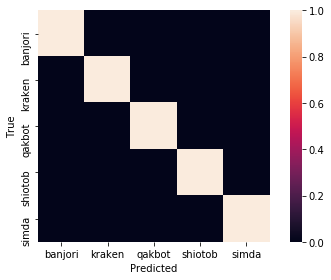

In [96]:
X, y = _build_ground_truth_dataframe()
clf = _cv(X, y, 10, 'DGA Classifier', RandomForestClassifier(n_estimators=100), 'dga-classifier.csv')

# Break DGA Classifier
Let's try to break the classifier. The rough idea is as follows:
* Examine the domains from the five classes
* Identify similarities and differences between them
* Choose an initial and target class. Now your goal is to make domains from the initial class "look like" the target class. I would recommend looking at:
  * Which characters are used
  * Which TLD (e.g., `.com` and `.net`) are used
  * Length (is it fixed? is it random within some range?)
* There's no one way to do this!

Some helpful hints:
* The classifier works on a group of `alpha=10` domains, i.e., 10 domains -> 1 feature vector.
* Take a look at the `_load_ground_truth()` function to retrieve and examine domains.
* `describe()` is your friend!

# Fix DGA Classifier
Using your function from the previous step, generate a set of _adversarial examples_ and use those to retrain the classifier. Show that it's more resistant. I would recommend:
* Generating the original ground truth dataset
* Appending your new vectors/labels to X and y
* Rerunning `_cv` to get a new classifier
* Checking if the new classifier can handle your perturbations